Our eventual goal is to generate features from the data, which can feed into a machine learning algorithm. The algorithm will make predictions about whether or not a loan will be paid off on time, which is contained in the `loan_status` column of the clean dataset.

As we prepared the data, we removed columns that had data leakage issues, contained redundant information, or required additional processing to turn into useful features. We cleaned features that had formatting issues, and converted categorical columns to dummy variables.

We noticed that there's a class imbalance in our target column, `loan_status`. There are about 6 times as many loans that were paid off on time (**positive case, label of `1`**) than those that weren't (**negative case, label of `0`). 
* Imbalances can cause issues with many machine learning algorithms, where they appear to have high accuracy, but actually aren't learning from the training data. Because of its potential to cause issues, we need to keep the class imbalance in mind as we build machine learning models.

In [1]:
import pandas as pd

loans = pd.read_csv("cleaned_loans_2007.csv")
print(loans.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37675 entries, 0 to 37674
Data columns (total 38 columns):
loan_amnt                              37675 non-null float64
int_rate                               37675 non-null float64
installment                            37675 non-null float64
emp_length                             37675 non-null int64
annual_inc                             37675 non-null float64
loan_status                            37675 non-null int64
dti                                    37675 non-null float64
delinq_2yrs                            37675 non-null float64
inq_last_6mths                         37675 non-null float64
open_acc                               37675 non-null float64
pub_rec                                37675 non-null float64
revol_bal                              37675 non-null float64
revol_util                             37675 non-null float64
total_acc                              37675 non-null float64
home_ownership_MORTGAGE    

Question we wanted to answer:

* Can we build a machine learning model that can accurately predict if a borrower will pay off their loan on time or not?

We established that this is a binary classification problem in the first project, and we converted the `loan_status` column to **0s and 1s** as a result. Before diving in and selecting an algorithm to apply to the data, we should select an **error metric**.

An **error metric** will help us figure out when our model is performing well, and when it's performing poorly. To tie error metrics all the way back to the original question we wanted to answer, let's say we're using a machine learning model to predict whether or not we should fund a loan on the Lending Club platform. Our objective in this is to make money -- we want to fund enough loans that are paid off on time to offset our losses from loans that aren't paid off. An error metric will help us determine if our algorithm will make us money or lose us money.

In this case, we're primarily concerned with **false positives** and **false negatives**. Both of these are different types of misclassifications. 
* With a **false positive**, we predict that a loan will be paid off on time, but it actually isn't. This costs us money, since we fund loans that lose us money. 
* With a **false negative**, we predict that a loan won't be paid off on time, but it actually would be paid off on time. This loses us potential money, since we didn't fund a loan that actually would have been paid off.

Since we're viewing this problem from the standpoint of a conservative investor, we need to treat **false positives** differently than **false negatives**. A conservative investor would want to minimize risk, and avoid **false positives** as much as possible. They'd be more okay with missing out on opportunities (**false negatives**) than they would be with funding a risky loan (**false positives**).

In this case, we don't want to use accuracy, and should instead use metrics that tell us the number of false positives and false negatives.

This means that we should optimize for:

* high [recall](https://en.wikipedia.org/wiki/Precision_and_recall#Recall) (true positive rate)
* low [fall-out](https://en.wikipedia.org/wiki/Information_retrieval#Fall-out) (false positive rate)

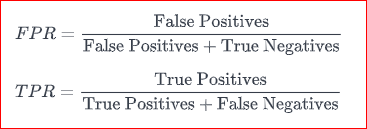

Simple english ways to think of each term are:

* `False Positive Rate`: The percentage of the loans that shouldn't be funded that we would fund.
* `True Positive Rate`: The percentage of loans that should be funded that we would fund.

Generally, if we want to reduce **false positive rate**, **true positive rate** will also go down. This is because if we want to reduce the risk of **false positives**, we wouldn't think about funding riskier loans in the first place.

Now that we've setup error metrics, we can move on to making predictions using a machine learning algorithm. our cleaned dataset contains `41` columns, all of which are either the **int64 or the float64** data type. There aren't any null values in any of the columns. This means that we can now apply any machine learning algorithm to our dataset. Most algorithms can't deal with non-numeric or missing values, which is why we had to do so much data cleaning.

A good first algorithm to apply to binary classification problems is [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression), for the following reasons:

* it's quick to train and we can iterate more quickly,
* it's less prone to overfitting than more complex models like decision trees,
* it's easy to interpret.

In [5]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [7]:
cols = loans.columns

train_cols = cols.drop("loan_status")
features = loans[train_cols]
labels = loans["loan_status"]

In [8]:
lr.fit(features, labels)
predictions = lr.predict(features)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


While we generated predictions, those predictions were overfit. They were overfit because we generated predictions using the same data that we trained our model on. When we use this to evaluate error, we get an unrealistically high depiction of how accurate the algorithm is, because it already **knows** the correct answers. 
* This is like asking someone to memorize a bunch of physics equations, then asking them to plug numbers into the equations. They can tell us the right answer, but they can't explain a concept that they haven't already memorized an equation for.

In order to get a realistic depiction of the accuracy of the model, let's perform[ k-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation). We can use the [cross_val_predict()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) function from the [sklearn.model_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) package. 

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
lr = LogisticRegression()
predictions = cross_val_predict(lr, features, labels, cv=3)
predictions = pd.Series(predictions)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [17]:
# False positives.
fp_filter = (predictions == 1) & (loans["loan_status"] == 0)
fp = len(predictions[fp_filter])

# True positives.
tp_filter = (predictions == 1) & (loans["loan_status"] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (loans["loan_status"] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (loans["loan_status"] == 0)
tn = len(predictions[tn_filter])

In [18]:
# Rates
tpr = tp  / (tp + fn)
fpr = fp  / (fp + tn)
print(tpr)
print(fpr)

0.9987920460880877
0.9962887363147152


Unfortunately, even though we're not using accuracy as an error metric, the classifier is, and it isn't accounting for the imbalance in the classes. There are a few ways to get a classifier to correct for imbalanced classes. The two main ways are:

* Use oversampling and undersampling to ensure that the classifier gets input that has a balanced number of each class.
* Tell the classifier to penalize misclassifications of the less prevalent class more than the other class.

We'll look into oversampling and undersampling first. 
* They involve taking a sample that contains equal numbers of rows where `loan_status` is **0**, and where `loan_status` is `1`. This way, the classifier is forced to make actual predictions, since predicting **all 1s or all 0s** will only result in **50%** accuracy at most.

The downside of this technique is that since it has to preserve an equal ratio, we have to either:

* Throw out many rows of data. If we wanted equal numbers of rows where `loan_status` is **0** and where `loan_status` is **1**, one way we could do that is to delete rows where `loan_status` is **1**.
* Copy rows multiple times. One way to equalize the **0s** and **1s** is to copy rows where `loan_status` is **0**.
* Generate fake data. One way to equalize the **0s** and **1s** is to generate new rows where `loan_status` is **0**.

Unfortunately, none of these techniques are especially easy. The second method, telling the classifier to penalize certain rows more, is actually much easier to implement using **scikit-learn**.

We can do this by setting the **class_weight** parameter to **balanced** when creating the `LogisticRegression` instance. This tells **scikit-learn** to penalize the misclassification of the minority class during the training process. The penalty means that the **logistic regression classifier** pays more attention to correctly classifying rows where `loan_status` is **0**. This lowers accuracy when `loan_status` is **1**, but raises accuracy when `loan_status` is **0**.

By setting the `class_weight` parameter to **balanced**, the penalty is set to be inversely proportional to the class frequencies. We can read more about the parameter [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn-linear-model-logisticregression). This would mean that for the classifier, **correctly classifying a row where `loan_status` is 0 is 6 times more important than correctly classifying a row where `loan_status` is 1**.

In [20]:
lr = LogisticRegression(class_weight = "balanced")
predictions = cross_val_predict(lr, features, labels, cv = 3)
predictions = pd.Series(predictions)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [21]:
# False positives.
fp_filter = (predictions == 1) & (loans["loan_status"] == 0)
fp = len(predictions[fp_filter])

# True positives.
tp_filter = (predictions == 1) & (loans["loan_status"] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (loans["loan_status"] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (loans["loan_status"] == 0)
tn = len(predictions[tn_filter])

# Rates
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(tpr)
print(fpr)

0.6644675710834418
0.3859714232696233


We significantly improved **false positive rate** by balancing the classes, which reduced **true positive rate**. Our **true positive rate is now around 66%**, and our **false positive rate is around 39%**. 

From a conservative investor's standpoint, it's reassuring that the **false positive rate is lower** because it means that we'll be able to do a better job at avoiding bad loans than if we funded everything. However, we'd only ever decide to fund **66% of the total loans (true positive rate)**, so we'd immediately reject a good amount of loans.

We can try to lower the false positive rate further by assigning a harsher penalty for misclassifying the negative class. While setting `class_weight` to **balanced** will automatically set a penalty based on the number of **1s and 0s** in the column, we can also set a manual penalty

In above code, the penalty **scikit-learn** imposed for misclassifying a `0` would have been around **5.89 (since there are 5.89 times as many 1s as 0s)**.

We can also specify a penalty manually if we want to adjust the rates more. To do this, we need to pass in a dictionary of penalty values to the `class_weight` parameter:

In [25]:
penalty = {
    0: 10,
    1: 1
}

The above dictionary will impose a **penalty of 10 for misclassifying a 0**, and a **penalty of 1 for misclassifying a 1**.

In [27]:
lr = LogisticRegression(class_weight=penalty)
predictions = cross_val_predict(lr, features, labels, cv=3)
predictions = pd.Series(predictions)

# False positives.
fp_filter = (predictions == 1) & (loans["loan_status"] == 0)
fp = len(predictions[fp_filter])

# True positives.
tp_filter = (predictions == 1) & (loans["loan_status"] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (loans["loan_status"] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (loans["loan_status"] == 0)
tn = len(predictions[tn_filter])

# Rates
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(tpr)
print(fpr)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.2514712259183547
0.09482278715902764


* It looks like assigning manual penalties lowered the **false positive rate to 9%**, and thus lowered our risk. Note that this comes at the expense of **true positive rate**. 
* While we have **fewer false positives**, we're also missing opportunities to fund more loans and potentially make more money. Given that we're approaching this as a conservative investor, this strategy makes sense, but it's worth keeping in mind the tradeoffs.

While we could tweak the penalties further, it's best to move to trying a different model right now, for larger potential **false positive rate** gains. We can always loop back and iterate on the penalties more later.

Let's try a more complex algorithm, **random forest**.  
* Random forests are able to work with nonlinear data, and learn complex conditionals. 
* Logistic regressions are only able to work with linear data. 

Training a **random forest** algorithm may enable us to get more accuracy due to columns that correlate nonlinearly with `loan_status`.

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
# from sklearn.cross_validation import cross_val_predict

In [29]:
rf = RandomForestClassifier(class_weight = "balanced", random_state = 1)

predictions = cross_val_predict(rf, features, labels, cv=3)
predictions = pd.Series(predictions)

# False positives.
fp_filter = (predictions == 1) & (loans["loan_status"] == 0)
fp = len(predictions[fp_filter])

# True positives.`
tp_filter = (predictions == 1) & (loans["loan_status"] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (loans["loan_status"] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (loans["loan_status"] == 0)
tn = len(predictions[tn_filter])

# Rates
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(tpr)
print(fpr)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9700799107972495
0.9181666357394693


Unfortunately, using a **random forest classifier didn't improve our false positive rate**. The model is likely weighting too heavily on the `1` class, and still mostly predicting **1s**. We could fix this by applying a harsher penalty for misclassifications of **0s**.

Ultimately, our best model had a **false positive rate of nearly 9%**, and a **true positive rate of nearly 25%**. For a conservative investor, this means that they make money as long as the interest rate is high enough to offset the losses from **9%** of borrowers defaulting, and that the pool of **25%** of borrowers is large enough to make enough interest money to offset the losses.

If we had randomly picked loans to fund, borrowers would have defaulted on **14.5%** of them, and our model is better than that, although we're excluding more loans than a random strategy would. Given this, there's still quite a bit of room to improve:

* We can tweak the penalties further.
* We can try models other than a random forest and logistic regression.
* We can use some of the columns we discarded to generate better features.
* We can ensemble multiple models to get more accurate predictions.
* We can tune the parameters of the algorithm to achieve higher performance.